In [235]:
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from collections import Counter
from collections import defaultdict

In [236]:
train=pd.read_csv('df_RFE_train.csv')
train=train.drop(columns=['Unnamed: 0','label'])
#train=train[(train['label']==1) | (train['label']==2)]
#train['label']=train['label'].map({1:0,2:1})

In [237]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7352 entries, 0 to 7351
Data columns (total 29 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   tBodyAcc-entropy()-X             7352 non-null   float64
 1   tBodyAcc-correlation()-X,Y       7352 non-null   float64
 2   tBodyAcc-correlation()-Y,Z       7352 non-null   float64
 3   tGravityAcc-mean()-Y             7352 non-null   float64
 4   tGravityAcc-max()-X              7352 non-null   float64
 5   tGravityAcc-max()-Z              7352 non-null   float64
 6   tGravityAcc-min()-X              7352 non-null   float64
 7   tGravityAcc-min()-Y              7352 non-null   float64
 8   tGravityAcc-energy()-Y           7352 non-null   float64
 9   tGravityAcc-arCoeff()-Y,1        7352 non-null   float64
 10  tGravityAcc-arCoeff()-Y,3        7352 non-null   float64
 11  tGravityAcc-arCoeff()-Z,2        7352 non-null   float64
 12  tGravityAcc-arCoeff(

In [238]:
X=train.values

In [239]:
X.ndim

2

In [240]:
X

array([[-0.40774707,  0.37631389,  0.66079033, ..., -0.9982852 ,
        -0.99069746,  0.17994061],
       [-0.71489166, -0.01342866,  0.57938169, ..., -0.99947194,
        -0.99639947,  0.18028889],
       [-0.59223514, -0.12469839,  0.60890014, ..., -0.99980673,
        -0.99512739,  0.18063731],
       ...,
       [ 0.17313063, -0.22682586, -0.19845192, ..., -0.64116959,
        -0.72637184,  0.24914484],
       [ 0.16033333, -0.25777522, -0.18991531, ..., -0.66357936,
        -0.6894209 ,  0.24643223],
       [ 0.3121799 , -0.26644248, -0.20029339, ..., -0.69808748,
        -0.74512041,  0.24680852]])

In [241]:
from sklearn.neighbors import LocalOutlierFactor
!pip install pyod
from pyod.models.abod import ABOD
from pyod.models.knn import KNN
from pyod.models.lof import LOF
from pyod.models.loci import LOCI

# Visual Approach

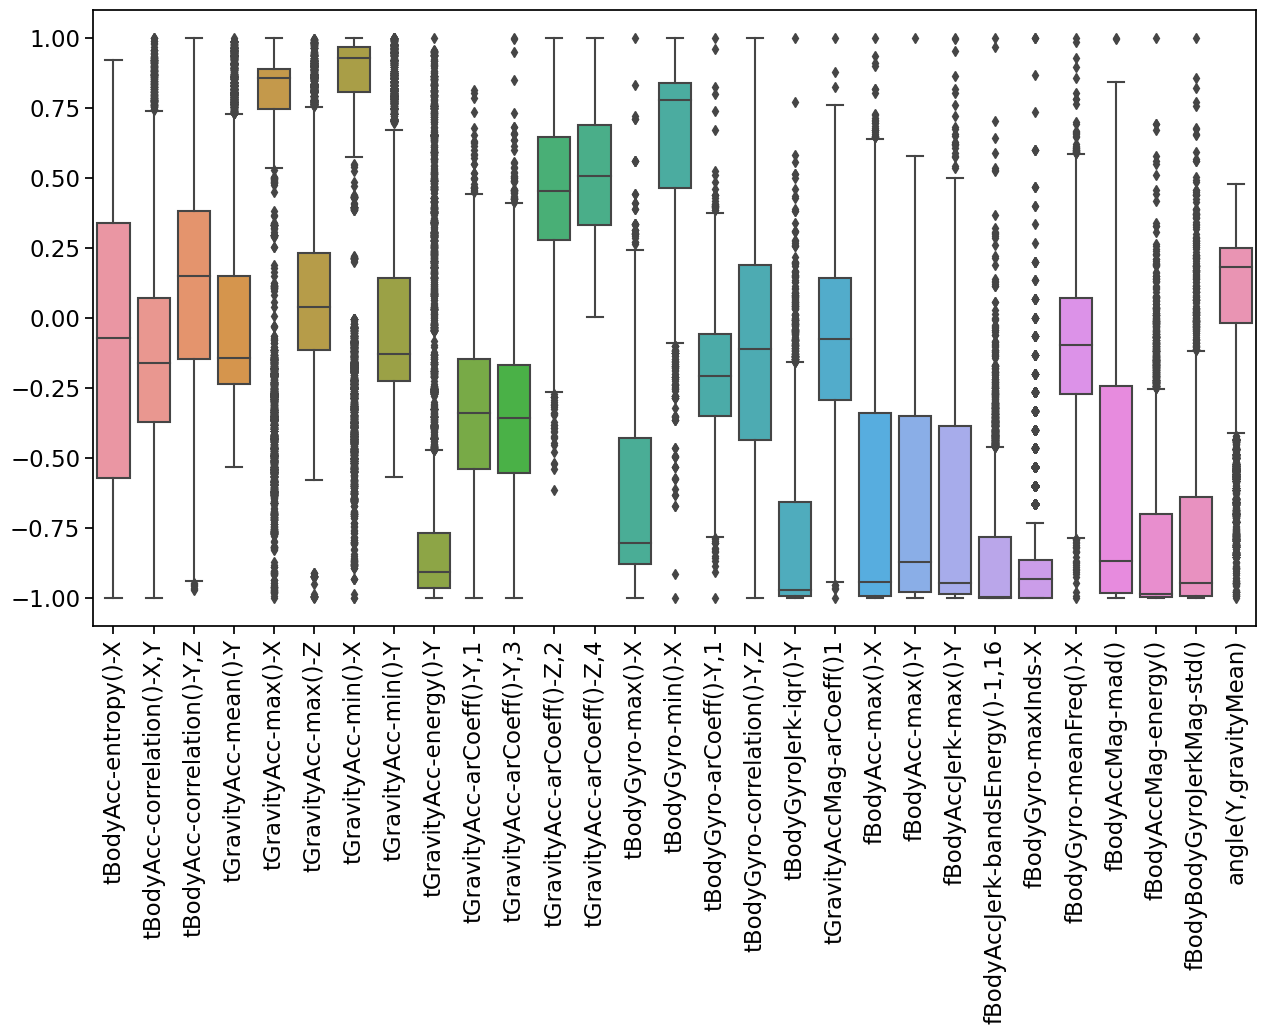

In [242]:
# boxplot
plt.figure(figsize=(15,8))
sns.set_context("notebook", font_scale=1.5, rc={"font.size":5,"axes.titlesize":5,"axes.labelsize":5})
sns.boxplot(data = train)
plt.xticks(rotation=90)
#plt.savefig('boxplot_out.png')
plt.show()


# Likelihood Approach

In [243]:
def norm_dist(x, mu, sigma):
    return 1/(np.sqrt(2*np.pi)*sigma) * np.e**(-((x-mu)**2)/(2*sigma**2))

def unif_dist(x, n):
    return 1/n

In [244]:
data = np.array(train['tBodyAcc-entropy()-X'])

In [245]:
M = np.copy(train['tBodyAcc-entropy()-X'])
A = []
lambda_par = 0.3

muM = np.mean(M)
sigmaM = np.std(M)
sizeA = len(A)

sumM = np.sum([norm_dist(x, muM, sigmaM) for x in M])

sumA = np.sum([unif_dist(x, sizeA) for x in A])

ll = (len(M) * np.log(1-lambda_par) + sumM + len(A) * np.log(lambda_par) + sumA)

In [246]:
M = np.copy(train['tBodyAcc-entropy()-X'])
A = []
c = 0.2
for i, x in enumerate(data):
    A.append(x)
    M = np.array([xo for j, xo in enumerate(data) if i!=j])
    muM = np.mean(M)
    sigmaM = np.std(M)
    sizeA = len(A)
    sumM = np.sum([norm_dist(x, muM, sigmaM) for x in M])
    sumA = np.sum([unif_dist(x, sizeA) for x in A])
    ll_xi = (len(M) * np.log(1-lambda_par) + sumM + len(A) * np.log(lambda_par) + sumA)
    delta_ll = abs(ll - ll_xi)
    M = np.copy(data)
    A = list()
    #print(i, delta_ll, 'outlier' if delta_ll > c else 'inlier')

# LOF with pyod (which we will use)

In [247]:
clf = LOF(contamination=0.05)
clf.fit(X)

outliers = clf.predict(X)
outliers

array([1, 0, 0, ..., 0, 0, 0])

In [248]:
np.unique(outliers, return_counts=True)

(array([0, 1]), array([7038,  314]))

In [249]:
train['anomaly']=clf.predict(X)
train.head()

,tBodyAcc-entropy()-X,"tBodyAcc-correlation()-X,Y","tBodyAcc-correlation()-Y,Z",tGravityAcc-mean()-Y,tGravityAcc-max()-X,tGravityAcc-max()-Z,tGravityAcc-min()-X,tGravityAcc-min()-Y,tGravityAcc-energy()-Y,"tGravityAcc-arCoeff()-Y,1",...,fBodyAcc-max()-Y,fBodyAccJerk-max()-Y,"fBodyAccJerk-bandsEnergy()-1,16",fBodyGyro-maxInds-X,fBodyGyro-meanFreq()-X,fBodyAccMag-mad(),fBodyAccMag-energy(),fBodyBodyGyroJerkMag-std(),"angle(Y,gravityMean)",anomaly
0,-0.407747,0.376314,0.660790,-0.140840,0.892055,0.124660,0.977436,-0.123213,-0.970905,-0.745449,...,-0.983163,-0.991975,-0.999982,-1.0,-0.257549,-0.948870,-0.998285,-0.990697,0.179941,1
1,-0.714892,-0.013429,0.579382,-0.141551,0.892060,0.122586,0.984520,-0.114893,-0.970583,-0.196359,...,-0.973770,-0.984923,-0.999987,-1.0,-0.048167,-0.975777,-0.999472,-0.996399,0.180289,0
2,-0.592235,-0.124698,0.608900,-0.142010,0.892401,0.094566,0.986770,-0.114893,-0.970368,-0.329023,...,-0.963072,-0.985351,-0.999963,-1.0,-0.216685,-0.985594,-0.999807,-0.995127,0.180637,0
3,-0.627446,-0.305693,0.507459,-0.143976,0.893817,0.093425,0.986821,-0.121336,-0.969400,-0.295036,...,-0.987275,-0.987874,-0.999978,-1.0,0.216862,-0.983524,-0.999770,-0.995237,0.181935,0
4,-0.786553,-0.155804,0.599213,-0.148750,0.893817,0.091682,0.987434,-0.121834,-0.967051,-0.166693,...,-0.980848,-0.990373,-0.999988,-1.0,-0.153343,-0.992324,-0.999873,-0.995465,0.185151,0


In [250]:
anomaly=train.loc[train['anomaly']==1]
anomaly_index=list(anomaly.index)
print(anomaly)

      tBodyAcc-entropy()-X  tBodyAcc-correlation()-X,Y  \
0                -0.407747                    0.376314   
30               -0.453269                   -0.026317   
31               -0.514607                   -0.489272   
66               -0.564789                    0.796651   
67               -0.295052                    0.835719   
...                    ...                         ...   
7189             -0.176182                   -0.240136   
7190             -0.206043                    0.022605   
7199             -0.240302                    0.160227   
7200              0.175464                   -0.660981   
7240             -0.397255                    0.382695   

      tBodyAcc-correlation()-Y,Z  tGravityAcc-mean()-Y  tGravityAcc-max()-X  \
0                       0.660790             -0.140840             0.892055   
30                     -0.362712              0.150702             0.768785   
31                      0.325030              0.195595            

In [251]:
anomaly

,tBodyAcc-entropy()-X,"tBodyAcc-correlation()-X,Y","tBodyAcc-correlation()-Y,Z",tGravityAcc-mean()-Y,tGravityAcc-max()-X,tGravityAcc-max()-Z,tGravityAcc-min()-X,tGravityAcc-min()-Y,tGravityAcc-energy()-Y,"tGravityAcc-arCoeff()-Y,1",...,fBodyAcc-max()-Y,fBodyAccJerk-max()-Y,"fBodyAccJerk-bandsEnergy()-1,16",fBodyGyro-maxInds-X,fBodyGyro-meanFreq()-X,fBodyAccMag-mad(),fBodyAccMag-energy(),fBodyBodyGyroJerkMag-std(),"angle(Y,gravityMean)",anomaly
0,-0.407747,0.376314,0.660790,-0.140840,0.892055,0.124660,0.977436,-0.123213,-0.970905,-0.745449,...,-0.983163,-0.991975,-0.999982,-1.000000,-0.257549,-0.948870,-0.998285,-0.990697,0.179941,1
30,-0.453269,-0.026317,-0.362712,0.150702,0.768785,0.376147,0.858348,0.167701,-0.944948,-0.577678,...,-0.807233,-0.908208,-0.995057,-0.933333,-0.382648,-0.569719,-0.875235,-0.802169,-0.020756,1
31,-0.514607,-0.489272,0.325030,0.195595,0.768785,0.440058,0.716291,0.174435,-0.906996,-0.711745,...,-0.586893,-0.897216,-0.993974,-0.933333,-0.748897,-0.566214,-0.866369,-0.837470,-0.053539,1
66,-0.564789,0.796651,-0.461665,0.755542,-0.091058,0.593725,-0.113391,0.742818,0.154649,-0.706948,...,-0.371145,-0.754118,-0.992986,-1.000000,-0.635256,-0.225444,-0.428831,-0.641397,-0.534122,1
67,-0.295052,0.835719,-0.532595,0.702622,-0.091207,0.763632,-0.361042,0.633282,0.008826,-0.723882,...,-0.188883,-0.739898,-0.992605,-1.000000,-0.684586,-0.323051,-0.613671,-0.685225,-0.488443,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7189,-0.176182,-0.240136,0.625496,-0.152530,0.897098,0.013978,0.989305,-0.128312,-0.965058,-0.405477,...,-0.856665,-0.905429,-0.997202,-1.000000,-0.193842,-0.734280,-0.956152,-0.574971,0.187881,1
7190,-0.206043,0.022605,0.731362,-0.124193,0.897098,0.089712,0.989841,-0.125790,-0.976773,-0.607735,...,-0.837925,-0.932559,-0.996860,-1.000000,-0.259147,-0.778288,-0.970145,-0.588047,0.168664,1
7199,-0.240302,0.160227,0.142763,-0.165050,0.892546,0.052448,0.985299,-0.140132,-0.958301,-0.122949,...,-0.845499,-0.887173,-0.999427,-1.000000,-0.299933,-0.897293,-0.990788,-0.872376,0.196527,1
7200,0.175464,-0.660981,-0.551580,0.455154,0.484576,0.559948,0.536417,0.435211,-0.567689,-0.977827,...,-0.926089,-0.991251,-0.999905,-1.000000,-0.189192,-0.954785,-0.998231,-0.995931,-0.246081,1


In [252]:
inlier=train.loc[train['anomaly']==0]

<ipython-input-253-e2b5095b094d>:27: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  legend.legendHandles[0]._sizes = [10]
<ipython-input-253-e2b5095b094d>:28: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  legend.legendHandles[1]._sizes = [20]


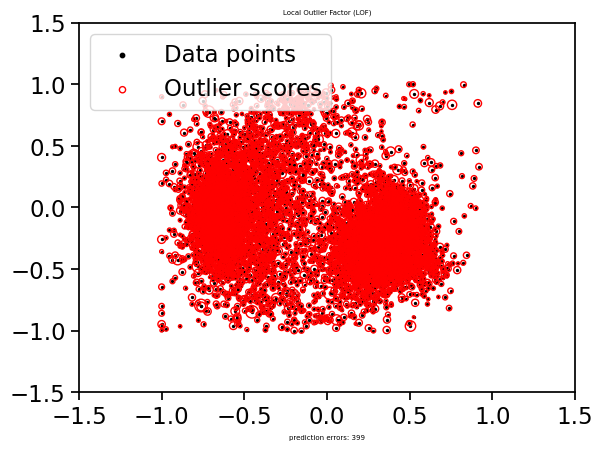

In [253]:
Xa = np.r_[inlier, anomaly]

n_outliers = len(anomaly)
ground_truth = np.ones(len(Xa), dtype=int)
ground_truth[-n_outliers:] = -1

# fit the model for outlier detection (default)
clf = LocalOutlierFactor(n_neighbors=3, contamination=0.03)
# use fit_predict to compute the predicted labels of the training samples
# (when LOF is used for outlier detection, the estimator has no predict,
# decision_function and score_samples methods).
y_pred = clf.fit_predict(Xa)
n_errors = (y_pred != ground_truth).sum()
X_scores = clf.negative_outlier_factor_

plt.title("Local Outlier Factor (LOF)")
plt.scatter(Xa[:, 0], Xa[:, 1], color='k', s=2., label='Data points')
# plot circles with radius proportional to the outlier scores
radius = (X_scores.max() - X_scores) / (X_scores.max() - X_scores.min())
plt.scatter(Xa[:, 0], Xa[:, 1], s=100 * radius, edgecolors='r',
            facecolors='none', label='Outlier scores')
plt.axis('tight')
plt.xlim((-1.5, 1.5))
plt.ylim((-1.5, 1.5))
plt.xlabel("prediction errors: %d" % (n_errors))
legend = plt.legend(loc='upper left')
legend.legendHandles[0]._sizes = [10]
legend.legendHandles[1]._sizes = [20]
plt.show()

In [254]:
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

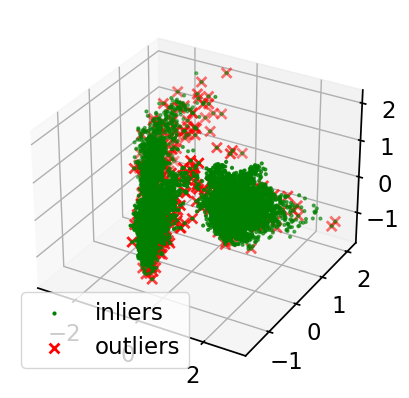

<Figure size 2000x2000 with 0 Axes>

In [255]:
pca = PCA(n_components=3)
X_reduce = pca.fit_transform(X)

fig = plt.figure()

ax = fig.add_subplot(111, projection='3d')
ax.set_zlabel("x_composite_3")
# Plot the compressed data points
ax.scatter(X_reduce[:, 0], X_reduce[:, 1], zs=X_reduce[:, 2], s=4, lw=1, label="inliers",c="green")
# Plot x's for the ground truth outliers
ax.scatter(X_reduce[anomaly_index,0],X_reduce[anomaly_index,1], X_reduce[anomaly_index,2],
           lw=2, s=50, marker="x", c="red", label="outliers")
ax.legend()
plt.figure(figsize=(20,20))
#plt.savefig('out_3d_LOF.png')
plt.show()

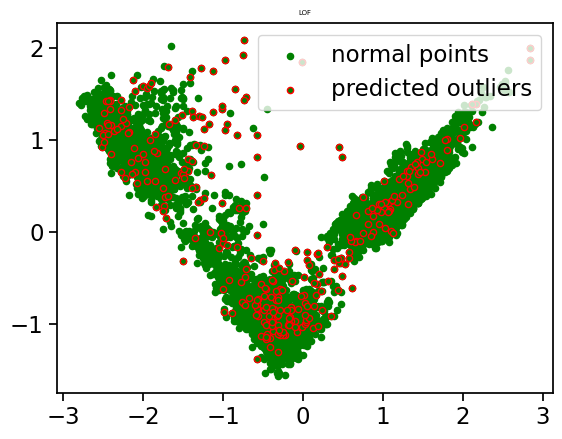

In [256]:
pca = PCA(2)
pca.fit(X)
res=pd.DataFrame(pca.transform(X))
#Z = np.array(res)
plt.title("LOF")
#plt.contourf( Z, cmap=plt.cm.Blues_r)
b1 = plt.scatter(res[0], res[1], c='green',
                 s=20,label="normal points")
b1 =plt.scatter(res.iloc[anomaly_index,0],res.iloc[anomaly_index,1], c='green',s=20,  edgecolor="red",label="predicted outliers")
plt.legend(loc="upper right")
plt.show()

# LOF with SCIKIT (we will not use it)

In [257]:
clf2 = LocalOutlierFactor(n_neighbors=5, contamination=0.02)
outliers2 = clf2.fit_predict(X)

In [258]:
clf2.negative_outlier_factor_

array([-1.82237244, -1.18085426, -1.08104788, ..., -1.00868556,
       -1.04594424, -1.06174532])

In [259]:
np.unique(outliers2, return_counts=True) #i -1 sono outliers

(array([-1,  1]), array([ 148, 7204]))

In [260]:
np.where(outliers2==-1)

(array([   0,   76,   77,  102,  176,  215,  237,  238,  270,  368,  390,
         481,  552,  564,  565,  570,  703,  777,  861,  920,  942,  989,
        1050, 1062, 1084, 1171, 1185, 1190, 1194, 1210, 1211, 1214, 1252,
        1340, 1343, 1369, 1372, 1393, 1396, 1528, 1535, 1547, 1728, 1729,
        1788, 1904, 2005, 2006, 2031, 2099, 2111, 2125, 2153, 2224, 2300,
        2433, 2437, 2440, 2451, 2531, 2532, 2602, 2985, 3129, 3130, 3131,
        3144, 3162, 3165, 3238, 3282, 3298, 3461, 3476, 3477, 3627, 3706,
        3728, 3729, 3750, 3829, 3830, 3863, 3885, 3900, 3915, 3946, 3952,
        3966, 4078, 4094, 4100, 4281, 4316, 4460, 4570, 4580, 4596, 4607,
        4613, 4730, 4744, 4769, 4827, 4871, 4880, 4939, 5066, 5108, 5140,
        5149, 5347, 5354, 5369, 5414, 5415, 5635, 5644, 5812, 5813, 5942,
        6002, 6147, 6152, 6161, 6168, 6172, 6495, 6518, 6519, 6686, 6687,
        6700, 6731, 6835, 6867, 6872, 6910, 6959, 7031, 7048, 7066, 7082,
        7188, 7189, 7199, 7240, 7294])

In [261]:
clf2.negative_outlier_factor_[np.where(outliers2==-1)]

array([-1.82237244, -1.4323105 , -1.52445751, -1.493162  , -1.80967192,
       -1.47710479, -1.44886096, -1.47063136, -1.42878864, -1.50048767,
       -1.55181583, -1.51035   , -1.53058072, -1.66291573, -1.78853932,
       -1.4588558 , -1.69713312, -1.45114945, -1.606602  , -1.65574986,
       -2.13958489, -1.5892098 , -1.48627612, -1.56494938, -1.47990459,
       -1.43753128, -1.41308025, -1.41192525, -1.52488952, -1.43612002,
       -1.43785562, -1.78612109, -1.55635056, -1.47699139, -1.46177006,
       -1.50291046, -1.47492748, -1.50392483, -1.62231677, -1.56545288,
       -1.59360603, -1.65699937, -1.63389689, -1.89817031, -1.49440573,
       -2.11555305, -1.50114102, -1.60152054, -1.68103781, -1.54369088,
       -1.6536843 , -1.50267794, -1.46361711, -1.4498643 , -1.75593218,
       -1.43426062, -1.50419923, -1.46613597, -1.50936252, -1.82206172,
       -1.72691356, -1.457061  , -1.45925852, -1.55466299, -2.32275907,
       -2.14803615, -1.44466522, -1.54633796, -1.8882575 , -1.43

In [262]:
max_val = np.max(clf2.negative_outlier_factor_[np.where(outliers2==-1)])
max_val #the least outlier compared to the others (they are not very negative values)

-1.4103337807712786

In [263]:
np.min(clf2.negative_outlier_factor_[np.where(outliers2==-1)]) #the most outlier

-2.3589924518536085

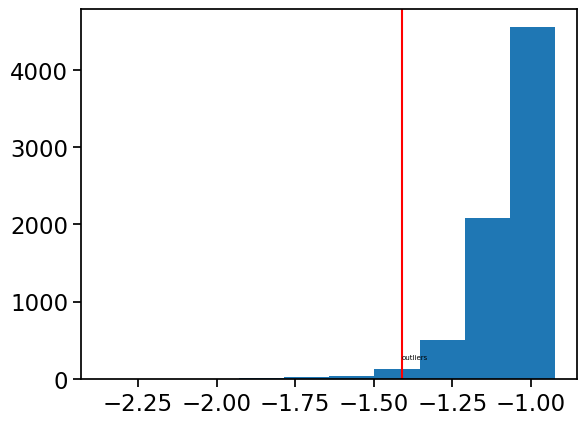

In [264]:
plt.hist(clf2.negative_outlier_factor_, bins=10)
plt.axvline(max_val, c='r')
plt.text(max_val, 250, 'outliers')
plt.show()

# ABOD

In [265]:
clf4 = ABOD(method="fast",contamination=0.1, n_neighbors=5)

In [266]:
clf4.fit(X)

ABOD(contamination=0.1, method='fast', n_neighbors=5)

In [267]:
train['anomaly2']=clf4.predict(X)
train.head()

,tBodyAcc-entropy()-X,"tBodyAcc-correlation()-X,Y","tBodyAcc-correlation()-Y,Z",tGravityAcc-mean()-Y,tGravityAcc-max()-X,tGravityAcc-max()-Z,tGravityAcc-min()-X,tGravityAcc-min()-Y,tGravityAcc-energy()-Y,"tGravityAcc-arCoeff()-Y,1",...,fBodyAccJerk-max()-Y,"fBodyAccJerk-bandsEnergy()-1,16",fBodyGyro-maxInds-X,fBodyGyro-meanFreq()-X,fBodyAccMag-mad(),fBodyAccMag-energy(),fBodyBodyGyroJerkMag-std(),"angle(Y,gravityMean)",anomaly,anomaly2
0,-0.407747,0.376314,0.660790,-0.140840,0.892055,0.124660,0.977436,-0.123213,-0.970905,-0.745449,...,-0.991975,-0.999982,-1.0,-0.257549,-0.948870,-0.998285,-0.990697,0.179941,1,1
1,-0.714892,-0.013429,0.579382,-0.141551,0.892060,0.122586,0.984520,-0.114893,-0.970583,-0.196359,...,-0.984923,-0.999987,-1.0,-0.048167,-0.975777,-0.999472,-0.996399,0.180289,0,0
2,-0.592235,-0.124698,0.608900,-0.142010,0.892401,0.094566,0.986770,-0.114893,-0.970368,-0.329023,...,-0.985351,-0.999963,-1.0,-0.216685,-0.985594,-0.999807,-0.995127,0.180637,0,0
3,-0.627446,-0.305693,0.507459,-0.143976,0.893817,0.093425,0.986821,-0.121336,-0.969400,-0.295036,...,-0.987874,-0.999978,-1.0,0.216862,-0.983524,-0.999770,-0.995237,0.181935,0,0
4,-0.786553,-0.155804,0.599213,-0.148750,0.893817,0.091682,0.987434,-0.121834,-0.967051,-0.166693,...,-0.990373,-0.999988,-1.0,-0.153343,-0.992324,-0.999873,-0.995465,0.185151,0,0


In [268]:
anomaly2=train.loc[train['anomaly2']==1]
anomaly2_index=list(anomaly2.index)
print(anomaly2)

      tBodyAcc-entropy()-X  tBodyAcc-correlation()-X,Y  \
0                -0.407747                    0.376314   
31               -0.514607                   -0.489272   
32               -0.366055                   -0.961165   
33                0.073576                   -0.910582   
51                0.583722                    0.492599   
...                    ...                         ...   
7240             -0.397255                    0.382695   
7247              0.467294                    0.358923   
7304              0.179529                   -0.282005   
7314              0.302629                   -0.388932   
7317             -0.143017                   -0.403499   

      tBodyAcc-correlation()-Y,Z  tGravityAcc-mean()-Y  tGravityAcc-max()-X  \
0                       0.660790             -0.140840             0.892055   
31                      0.325030              0.195595             0.768785   
32                      0.887389              0.314068            

In [269]:
clf4.labels_

array([1, 0, 0, ..., 0, 0, 0])

In [270]:
clf4.decision_scores_

array([-0.01084802, -0.14984182, -1.1306462 , ..., -2.70415541,
       -1.20177074, -0.93150069])

In [271]:
np.unique(clf4.labels_, return_counts=True)

(array([0, 1]), array([6616,  736]))

In [272]:
clf4.threshold_

-0.13397960549822946

In [273]:
clf4.decision_function(X)

array([-0.01181767, -0.15267422, -1.07407375, ..., -2.71469083,
       -0.76084116, -1.02465473])

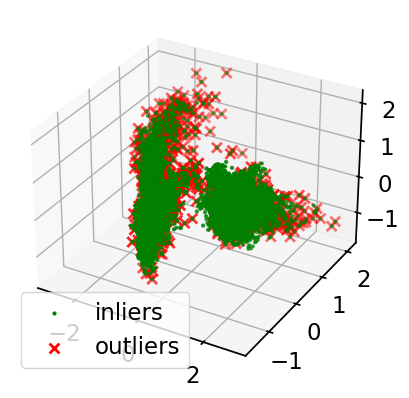

In [274]:
pca2 = PCA(n_components=3)
X2_reduce = pca2.fit_transform(X)

fig = plt.figure()

ax = fig.add_subplot(111, projection='3d')
ax.set_zlabel("x_composite_3")
# Plot the compressed data points
ax.scatter(X2_reduce[:, 0], X2_reduce[:, 1], zs=X2_reduce[:, 2], s=4, lw=1, label="inliers",c="green")
# Plot x's for the ground truth outliers
ax.scatter(X2_reduce[anomaly2_index,0],X2_reduce[anomaly2_index,1], X2_reduce[anomaly2_index,2],
           lw=2, s=50, marker="x", c="red", label="outliers")
ax.legend()
#plt.figure(figsize=(40,40))
#plt.savefig('out_ABOD0.01_3d.png')
plt.show()

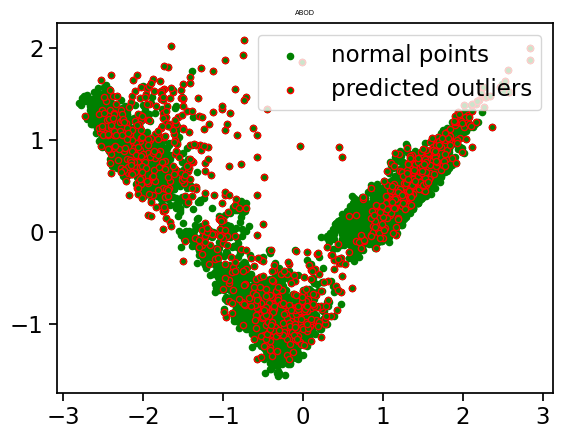

In [275]:
pca2 = PCA(2)
pca2.fit(X)
res=pd.DataFrame(pca2.transform(X))
#Z = np.array(res)
plt.title("ABOD")
#plt.contourf( Z, cmap=plt.cm.Blues_r)
b1 = plt.scatter(res[0], res[1], c='green',
                 s=20,label="normal points")
b1 =plt.scatter(res.iloc[anomaly2_index,0],res.iloc[anomaly2_index,1], c='green',s=20,  edgecolor="red",label="predicted outliers")
plt.legend(loc="upper right")
plt.show()
#plt.savefig('out_ABOD0.01_2d.png')

# Isolation Forest

In [276]:
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split

In [277]:
random_state = np.random.RandomState(42)

In [278]:
model = IsolationForest(contamination=float(0.02),random_state=random_state)
model.fit(X)

IsolationForest(contamination=0.02,
                random_state=RandomState(MT19937) at 0x7C527CC7D140)

In [279]:
model.get_params()

{'bootstrap': False,
 'contamination': 0.02,
 'max_features': 1.0,
 'max_samples': 'auto',
 'n_estimators': 100,
 'n_jobs': None,
 'random_state': RandomState(MT19937) at 0x7C527CC7D140,
 'verbose': 0,
 'warm_start': False}

In [280]:
train['anomaly_forest']=model.predict(X)

train.head(20)

,tBodyAcc-entropy()-X,"tBodyAcc-correlation()-X,Y","tBodyAcc-correlation()-Y,Z",tGravityAcc-mean()-Y,tGravityAcc-max()-X,tGravityAcc-max()-Z,tGravityAcc-min()-X,tGravityAcc-min()-Y,tGravityAcc-energy()-Y,"tGravityAcc-arCoeff()-Y,1",...,"fBodyAccJerk-bandsEnergy()-1,16",fBodyGyro-maxInds-X,fBodyGyro-meanFreq()-X,fBodyAccMag-mad(),fBodyAccMag-energy(),fBodyBodyGyroJerkMag-std(),"angle(Y,gravityMean)",anomaly,anomaly2,anomaly_forest
0,-0.407747,0.376314,0.660790,-0.140840,0.892055,0.124660,0.977436,-0.123213,-0.970905,-0.745449,...,-0.999982,-1.000000,-0.257549,-0.948870,-0.998285,-0.990697,0.179941,1,1,1
1,-0.714892,-0.013429,0.579382,-0.141551,0.892060,0.122586,0.984520,-0.114893,-0.970583,-0.196359,...,-0.999987,-1.000000,-0.048167,-0.975777,-0.999472,-0.996399,0.180289,0,0,1
2,-0.592235,-0.124698,0.608900,-0.142010,0.892401,0.094566,0.986770,-0.114893,-0.970368,-0.329023,...,-0.999963,-1.000000,-0.216685,-0.985594,-0.999807,-0.995127,0.180637,0,0,1
3,-0.627446,-0.305693,0.507459,-0.143976,0.893817,0.093425,0.986821,-0.121336,-0.969400,-0.295036,...,-0.999978,-1.000000,0.216862,-0.983524,-0.999770,-0.995237,0.181935,0,0,1
4,-0.786553,-0.155804,0.599213,-0.148750,0.893817,0.091682,0.987434,-0.121834,-0.967051,-0.166693,...,-0.999988,-1.000000,-0.153343,-0.992324,-0.999873,-0.995465,0.185151,0,0,1
5,-0.751869,-0.209979,0.180424,-0.148210,0.893683,0.083347,0.987722,-0.121834,-0.967321,-0.198125,...,-0.999987,-0.933333,-0.363040,-0.993851,-0.999939,-0.995239,0.184823,0,0,1
6,-0.637185,-0.095852,0.610845,-0.144282,0.893370,0.085206,0.987722,-0.120092,-0.969266,-0.422670,...,-0.999983,-1.000000,-0.307125,-0.982490,-0.999676,-0.994639,0.182170,0,0,1
7,-0.633239,-0.161634,0.561421,-0.146705,0.894205,0.085206,0.987926,-0.128559,-0.968033,-0.470618,...,-0.999980,-0.866667,-0.088136,-0.976829,-0.999470,-0.994507,0.183779,0,0,1
8,-0.683117,-0.164791,0.724234,-0.154374,0.894205,0.084474,0.987754,-0.129764,-0.964123,-0.328687,...,-0.999987,-1.000000,-0.184055,-0.979264,-0.999520,-0.996007,0.188982,0,0,1
9,-0.550721,-0.176241,0.391867,-0.156302,0.894778,0.073488,0.987754,-0.129764,-0.963137,-0.362308,...,-0.999953,-0.533333,-0.172768,-0.987825,-0.999777,-0.990599,0.190310,0,0,1


In [281]:
anomaly_forest=train.loc[train['anomaly_forest']==-1]
anomaly_forest_index=list(anomaly_forest.index)
print(anomaly_forest_index)

[66, 67, 68, 69, 70, 71, 72, 237, 238, 240, 241, 245, 247, 739, 751, 753, 896, 1049, 1050, 1052, 1062, 1209, 1210, 1211, 1214, 1223, 1266, 1267, 1271, 1272, 1273, 1274, 1275, 1276, 1277, 1279, 1283, 1369, 1523, 1645, 1724, 1813, 1826, 1827, 1925, 1951, 2111, 2288, 2412, 2440, 2441, 2451, 2510, 2511, 2512, 2514, 2570, 2597, 2611, 2612, 2613, 2762, 2787, 3149, 3493, 3683, 3760, 3764, 3880, 3887, 3891, 3892, 3894, 3895, 3896, 3898, 3899, 3900, 3928, 3929, 3930, 3932, 3933, 3934, 3935, 3936, 3937, 3938, 3939, 3953, 3954, 3955, 3957, 3958, 3960, 3961, 4057, 4258, 4282, 4435, 4450, 4597, 4613, 4615, 4617, 4618, 4945, 5137, 5138, 5139, 5140, 5141, 5142, 5143, 5144, 5145, 5146, 5147, 5148, 5149, 5150, 5151, 5153, 5154, 5155, 5339, 5346, 5347, 5351, 5352, 5355, 5360, 5365, 5368, 5369, 5370, 5557, 5574, 5742, 5761, 6128, 6332, 6341, 6344, 6516, 6880, 7230, 7247]


In [282]:
len(anomaly_forest_index)

148

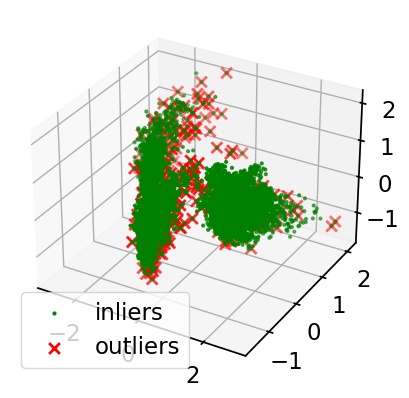

In [283]:
pca = PCA(n_components=3)  # Reduce to k=3 dimensions
X_reduce = pca.fit_transform(X)

fig = plt.figure()

ax = fig.add_subplot(111, projection='3d')
ax.set_zlabel("x_composite_3")
# Plot the compressed data points
ax.scatter(X_reduce[:, 0], X_reduce[:, 1], zs=X_reduce[:, 2], s=4, lw=1, label="inliers",c="green")
# Plot x's for the ground truth outliers
ax.scatter(X_reduce[anomaly_index,0],X_reduce[anomaly_index,1], X_reduce[anomaly_index,2],
           lw=2, s=60, marker="x", c="red", label="outliers")
ax.legend()
#plt.figure(figsize=(20,20))
#plt.savefig('out_3d.png')
plt.show()

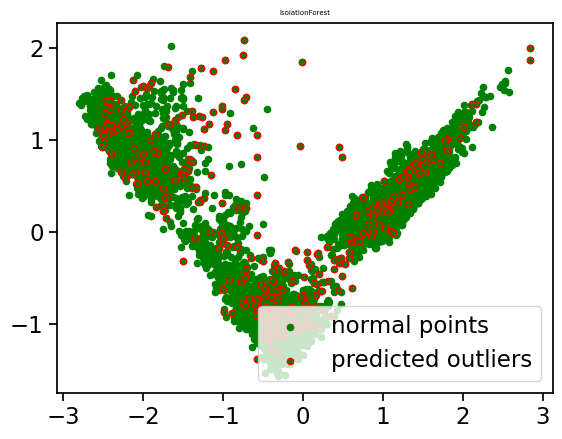

In [284]:
pca = PCA(2)
pca.fit(X)
res=pd.DataFrame(pca.transform(X))
#Z = np.array(res)
plt.title("IsolationForest")
#plt.contourf( Z, cmap=plt.cm.Blues_r)
b1 = plt.scatter(res[0], res[1], c='green',
                 s=20,label="normal points")
b1 =plt.scatter(res.iloc[anomaly_index,0],res.iloc[anomaly_index,1], c='green',s=20,  edgecolor="red",label="predicted outliers")
plt.legend(loc= 'lower right')
plt.show()

# Extended isolation forest

In [285]:
#!pip install h2o
import h2o
from h2o.estimators import H2OExtendedIsolationForestEstimator
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,33 mins 42 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.42.0.3
H2O_cluster_version_age:,27 days
H2O_cluster_name:,H2O_from_python_unknownUser_kbu8kd
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.148 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


In [286]:
train2 = h2o.import_file('df_RFE_train.csv')

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [287]:
train2.drop(['label'])

C1,tBodyAcc-entropy()-X,"tBodyAcc-correlation()-X,Y","tBodyAcc-correlation()-Y,Z",tGravityAcc-mean()-Y,tGravityAcc-max()-X,tGravityAcc-max()-Z,tGravityAcc-min()-X,tGravityAcc-min()-Y,tGravityAcc-energy()-Y,"tGravityAcc-arCoeff()-Y,1","tGravityAcc-arCoeff()-Y,3","tGravityAcc-arCoeff()-Z,2","tGravityAcc-arCoeff()-Z,4",tBodyGyro-max()-X,tBodyGyro-min()-X,"tBodyGyro-arCoeff()-Y,1","tBodyGyro-correlation()-Y,Z",tBodyGyroJerk-iqr()-Y,tGravityAccMag-arCoeff()1,fBodyAcc-max()-X,fBodyAcc-max()-Y,fBodyAccJerk-max()-Y,"fBodyAccJerk-bandsEnergy()-1,16",fBodyGyro-maxInds-X,fBodyGyro-meanFreq()-X,fBodyAccMag-mad(),fBodyAccMag-energy(),fBodyBodyGyroJerkMag-std(),"angle(Y,gravityMean)"
0,-0.407747,0.376314,0.66079,-0.14084,0.892055,0.12466,0.977436,-0.123213,-0.970905,-0.745449,-0.712372,0.995675,0.991653,-0.867044,0.847308,1,0.301099,-0.996939,-0.173179,-0.993756,-0.983163,-0.991975,-0.999982,-1,-0.257549,-0.94887,-0.998285,-0.990697,0.179941
1,-0.714892,-0.0134287,0.579382,-0.141551,0.89206,0.122586,0.98452,-0.114893,-0.970583,-0.196359,-0.105568,0.834271,0.830464,-0.864904,0.833721,-0.0470318,0.169395,-0.997301,0.0815686,-0.999372,-0.97377,-0.984923,-0.999987,-1,-0.0481674,-0.975777,-0.999472,-0.996399,0.180289
2,-0.592235,-0.124698,0.6089,-0.14201,0.892401,0.0945658,0.98677,-0.114893,-0.970368,-0.329023,-0.25449,0.714392,0.728755,-0.864904,0.833721,0.0323116,-0.350646,-0.995428,0.0380491,-0.998158,-0.963072,-0.985351,-0.999963,-1,-0.216685,-0.985594,-0.999807,-0.995127,0.180637
3,-0.627446,-0.305693,0.507459,-0.143976,0.893817,0.0934247,0.986821,-0.121336,-0.9694,-0.295036,-0.206281,0.386373,0.385263,-0.88532,0.834164,0.0445532,-0.725301,-0.997078,-0.0928559,-0.997404,-0.987275,-0.987874,-0.999978,-1,0.216862,-0.983524,-0.99977,-0.995237,0.181935
4,-0.786553,-0.155804,0.599213,-0.14875,0.893817,0.0916824,0.987434,-0.121834,-0.967051,-0.166693,-0.0663267,0.239268,0.240569,-0.870154,0.839091,-0.163221,-0.724558,-0.996718,0.180441,-0.999277,-0.980848,-0.990373,-0.999988,-1,-0.153343,-0.992324,-0.999873,-0.995465,0.185151
5,-0.751869,-0.209979,0.180424,-0.14821,0.893683,0.0833471,0.987722,-0.121834,-0.967321,-0.198125,-0.107554,0.175375,0.207965,-0.870154,0.839808,-0.119692,-0.745979,-0.996122,0.370339,-0.998598,-0.993414,-0.992801,-0.999987,-0.933333,-0.36304,-0.993851,-0.999939,-0.995239,0.184823
6,-0.637185,-0.0958521,0.610845,-0.144282,0.89337,0.0852057,0.987722,-0.120092,-0.969266,-0.42267,-0.362169,0.137692,0.153476,-0.880846,0.839232,-0.0468876,-0.687681,-0.996192,0.15592,-0.996957,-0.968729,-0.991111,-0.999983,-1,-0.307125,-0.98249,-0.999676,-0.994639,0.18217
7,-0.633239,-0.161634,0.561421,-0.146705,0.894205,0.0852057,0.987926,-0.128559,-0.968033,-0.470618,-0.405063,0.139173,0.129649,-0.878916,0.839232,-0.0858853,-0.73265,-0.996285,0.0496637,-0.998347,-0.962426,-0.988152,-0.99998,-0.866667,-0.0881359,-0.976829,-0.99947,-0.994507,0.183779
8,-0.683117,-0.164791,0.724234,-0.154374,0.894205,0.0844737,0.987754,-0.129764,-0.964123,-0.328687,-0.239881,0.503643,0.496765,-0.878916,0.842403,-0.171022,-0.442481,-0.996964,0.382674,-0.997174,-0.953859,-0.98537,-0.999987,-1,-0.184055,-0.979264,-0.99952,-0.996007,0.188982
9,-0.550721,-0.176241,0.391867,-0.156302,0.894778,0.0734882,0.987754,-0.129764,-0.963137,-0.362308,-0.310721,0.484213,0.514929,-0.871571,0.836739,-0.204035,-0.446921,-0.99337,0.430695,-0.996913,-0.984395,-0.975047,-0.999953,-0.533333,-0.172768,-0.987825,-0.999777,-0.990599,0.19031


In [288]:
eif = H2OExtendedIsolationForestEstimator(ntrees=100,sample_size = 256,
                                          extension_level = 28)

eif.train(training_frame = train2)
eif_result = eif.predict(train2)

extendedisolationforest Model Build progress: |██████████████████████████████████| (done) 100%
extendedisolationforest prediction progress: |███████████████████████████████████| (done) 100%


In [289]:
eif_result

anomaly_score,mean_length
0.640059,6.59481
0.636173,6.68481
0.634743,6.71808
0.634743,6.71808
0.633519,6.74659
0.633519,6.74659
0.63138,6.79659
0.630952,6.80659
0.628822,6.85659
0.632234,6.77659


# Compara le colonne di outliers

In [290]:
outcommon= set(anomaly_forest_index) & set(anomaly_index) & set(anomaly2_index)
outcommon #with ISOFOREST cont=0.02 , ABOD cont=0.02 and k=5, LOF cont=0.05 there are 35 outliers in common, changing
#ABOD cont=0.05 they increase to 51, and changing LOF 0.1 with ABOD 0.05 they increase to 61

{66,
 67,
 69,
 70,
 71,
 72,
 237,
 238,
 247,
 1062,
 1209,
 1210,
 1211,
 1214,
 1369,
 1523,
 1813,
 1826,
 1925,
 2111,
 2412,
 2440,
 2451,
 2511,
 2570,
 3149,
 3493,
 3894,
 3896,
 3899,
 3934,
 3935,
 3960,
 4597,
 4613,
 5137,
 5138,
 5140,
 5141,
 5143,
 5148,
 5149,
 5150,
 5151,
 5153,
 5154,
 5346,
 5347,
 5351,
 5355,
 5369,
 5370,
 6516}

In [291]:
len(outcommon)

53

In [292]:
listout=list(outcommon)

In [293]:
train

,tBodyAcc-entropy()-X,"tBodyAcc-correlation()-X,Y","tBodyAcc-correlation()-Y,Z",tGravityAcc-mean()-Y,tGravityAcc-max()-X,tGravityAcc-max()-Z,tGravityAcc-min()-X,tGravityAcc-min()-Y,tGravityAcc-energy()-Y,"tGravityAcc-arCoeff()-Y,1",...,"fBodyAccJerk-bandsEnergy()-1,16",fBodyGyro-maxInds-X,fBodyGyro-meanFreq()-X,fBodyAccMag-mad(),fBodyAccMag-energy(),fBodyBodyGyroJerkMag-std(),"angle(Y,gravityMean)",anomaly,anomaly2,anomaly_forest
0,-0.407747,0.376314,0.660790,-0.140840,0.892055,0.124660,0.977436,-0.123213,-0.970905,-0.745449,...,-0.999982,-1.000000,-0.257549,-0.948870,-0.998285,-0.990697,0.179941,1,1,1
1,-0.714892,-0.013429,0.579382,-0.141551,0.892060,0.122586,0.984520,-0.114893,-0.970583,-0.196359,...,-0.999987,-1.000000,-0.048167,-0.975777,-0.999472,-0.996399,0.180289,0,0,1
2,-0.592235,-0.124698,0.608900,-0.142010,0.892401,0.094566,0.986770,-0.114893,-0.970368,-0.329023,...,-0.999963,-1.000000,-0.216685,-0.985594,-0.999807,-0.995127,0.180637,0,0,1
3,-0.627446,-0.305693,0.507459,-0.143976,0.893817,0.093425,0.986821,-0.121336,-0.969400,-0.295036,...,-0.999978,-1.000000,0.216862,-0.983524,-0.999770,-0.995237,0.181935,0,0,1
4,-0.786553,-0.155804,0.599213,-0.148750,0.893817,0.091682,0.987434,-0.121834,-0.967051,-0.166693,...,-0.999988,-1.000000,-0.153343,-0.992324,-0.999873,-0.995465,0.185151,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7347,0.195643,-0.211822,-0.283335,-0.222004,0.867718,-0.016391,0.920554,-0.234998,-0.918375,-0.689028,...,-0.775736,-1.000000,-0.434780,-0.007392,-0.584282,-0.723951,0.238604,0,0,1
7348,0.178138,-0.198555,-0.274504,-0.242054,0.866116,-0.016391,0.920554,-0.234998,-0.902880,-0.662997,...,-0.780751,-0.933333,-0.516570,-0.172448,-0.632536,-0.771183,0.252676,0,0,1
7349,0.173131,-0.226826,-0.198452,-0.236950,0.854641,0.024684,0.933008,-0.216004,-0.907561,-0.459707,...,-0.783616,-0.933333,-0.289537,-0.216074,-0.641170,-0.726372,0.249145,0,0,1
7350,0.160333,-0.257775,-0.189915,-0.233230,0.855988,0.024684,0.933008,-0.210542,-0.910648,-0.418440,...,-0.821137,-0.933333,-0.362980,-0.220443,-0.663579,-0.689421,0.246432,0,0,1


In [294]:
train2=train.drop(outcommon)
train2

,tBodyAcc-entropy()-X,"tBodyAcc-correlation()-X,Y","tBodyAcc-correlation()-Y,Z",tGravityAcc-mean()-Y,tGravityAcc-max()-X,tGravityAcc-max()-Z,tGravityAcc-min()-X,tGravityAcc-min()-Y,tGravityAcc-energy()-Y,"tGravityAcc-arCoeff()-Y,1",...,"fBodyAccJerk-bandsEnergy()-1,16",fBodyGyro-maxInds-X,fBodyGyro-meanFreq()-X,fBodyAccMag-mad(),fBodyAccMag-energy(),fBodyBodyGyroJerkMag-std(),"angle(Y,gravityMean)",anomaly,anomaly2,anomaly_forest
0,-0.407747,0.376314,0.660790,-0.140840,0.892055,0.124660,0.977436,-0.123213,-0.970905,-0.745449,...,-0.999982,-1.000000,-0.257549,-0.948870,-0.998285,-0.990697,0.179941,1,1,1
1,-0.714892,-0.013429,0.579382,-0.141551,0.892060,0.122586,0.984520,-0.114893,-0.970583,-0.196359,...,-0.999987,-1.000000,-0.048167,-0.975777,-0.999472,-0.996399,0.180289,0,0,1
2,-0.592235,-0.124698,0.608900,-0.142010,0.892401,0.094566,0.986770,-0.114893,-0.970368,-0.329023,...,-0.999963,-1.000000,-0.216685,-0.985594,-0.999807,-0.995127,0.180637,0,0,1
3,-0.627446,-0.305693,0.507459,-0.143976,0.893817,0.093425,0.986821,-0.121336,-0.969400,-0.295036,...,-0.999978,-1.000000,0.216862,-0.983524,-0.999770,-0.995237,0.181935,0,0,1
4,-0.786553,-0.155804,0.599213,-0.148750,0.893817,0.091682,0.987434,-0.121834,-0.967051,-0.166693,...,-0.999988,-1.000000,-0.153343,-0.992324,-0.999873,-0.995465,0.185151,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7347,0.195643,-0.211822,-0.283335,-0.222004,0.867718,-0.016391,0.920554,-0.234998,-0.918375,-0.689028,...,-0.775736,-1.000000,-0.434780,-0.007392,-0.584282,-0.723951,0.238604,0,0,1
7348,0.178138,-0.198555,-0.274504,-0.242054,0.866116,-0.016391,0.920554,-0.234998,-0.902880,-0.662997,...,-0.780751,-0.933333,-0.516570,-0.172448,-0.632536,-0.771183,0.252676,0,0,1
7349,0.173131,-0.226826,-0.198452,-0.236950,0.854641,0.024684,0.933008,-0.216004,-0.907561,-0.459707,...,-0.783616,-0.933333,-0.289537,-0.216074,-0.641170,-0.726372,0.249145,0,0,1
7350,0.160333,-0.257775,-0.189915,-0.233230,0.855988,0.024684,0.933008,-0.210542,-0.910648,-0.418440,...,-0.821137,-0.933333,-0.362980,-0.220443,-0.663579,-0.689421,0.246432,0,0,1


In [295]:
#train2.to_csv("df_RFE_NoOUt.csv")

In [296]:
trainpul = train2.drop(columns = ["anomaly_forest",'anomaly','anomaly2'])

In [297]:
trainpul

,tBodyAcc-entropy()-X,"tBodyAcc-correlation()-X,Y","tBodyAcc-correlation()-Y,Z",tGravityAcc-mean()-Y,tGravityAcc-max()-X,tGravityAcc-max()-Z,tGravityAcc-min()-X,tGravityAcc-min()-Y,tGravityAcc-energy()-Y,"tGravityAcc-arCoeff()-Y,1",...,fBodyAcc-max()-X,fBodyAcc-max()-Y,fBodyAccJerk-max()-Y,"fBodyAccJerk-bandsEnergy()-1,16",fBodyGyro-maxInds-X,fBodyGyro-meanFreq()-X,fBodyAccMag-mad(),fBodyAccMag-energy(),fBodyBodyGyroJerkMag-std(),"angle(Y,gravityMean)"
0,-0.407747,0.376314,0.660790,-0.140840,0.892055,0.124660,0.977436,-0.123213,-0.970905,-0.745449,...,-0.993756,-0.983163,-0.991975,-0.999982,-1.000000,-0.257549,-0.948870,-0.998285,-0.990697,0.179941
1,-0.714892,-0.013429,0.579382,-0.141551,0.892060,0.122586,0.984520,-0.114893,-0.970583,-0.196359,...,-0.999372,-0.973770,-0.984923,-0.999987,-1.000000,-0.048167,-0.975777,-0.999472,-0.996399,0.180289
2,-0.592235,-0.124698,0.608900,-0.142010,0.892401,0.094566,0.986770,-0.114893,-0.970368,-0.329023,...,-0.998158,-0.963072,-0.985351,-0.999963,-1.000000,-0.216685,-0.985594,-0.999807,-0.995127,0.180637
3,-0.627446,-0.305693,0.507459,-0.143976,0.893817,0.093425,0.986821,-0.121336,-0.969400,-0.295036,...,-0.997404,-0.987275,-0.987874,-0.999978,-1.000000,0.216862,-0.983524,-0.999770,-0.995237,0.181935
4,-0.786553,-0.155804,0.599213,-0.148750,0.893817,0.091682,0.987434,-0.121834,-0.967051,-0.166693,...,-0.999277,-0.980848,-0.990373,-0.999988,-1.000000,-0.153343,-0.992324,-0.999873,-0.995465,0.185151
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7347,0.195643,-0.211822,-0.283335,-0.222004,0.867718,-0.016391,0.920554,-0.234998,-0.918375,-0.689028,...,-0.318185,-0.224135,-0.614001,-0.775736,-1.000000,-0.434780,-0.007392,-0.584282,-0.723951,0.238604
7348,0.178138,-0.198555,-0.274504,-0.242054,0.866116,-0.016391,0.920554,-0.234998,-0.902880,-0.662997,...,-0.332146,-0.261767,-0.613520,-0.780751,-0.933333,-0.516570,-0.172448,-0.632536,-0.771183,0.252676
7349,0.173131,-0.226826,-0.198452,-0.236950,0.854641,0.024684,0.933008,-0.216004,-0.907561,-0.459707,...,-0.160368,-0.263932,-0.626141,-0.783616,-0.933333,-0.289537,-0.216074,-0.641170,-0.726372,0.249145
7350,0.160333,-0.257775,-0.189915,-0.233230,0.855988,0.024684,0.933008,-0.210542,-0.910648,-0.418440,...,-0.147421,-0.262225,-0.542854,-0.821137,-0.933333,-0.362980,-0.220443,-0.663579,-0.689421,0.246432


In [298]:
#trainpul.to_csv("df_RFE_6Class_LOF.csv")

# Various tests

In [299]:
from pyod.models.abod import ABOD
from pyod.models.iforest import IForest
from pyod.models.lof import LOF
from pyod.models.knn import KNN


In [300]:
clf = ABOD(method="fast", n_neighbors=3, contamination=0.2)

In [301]:
clf.fit(X)

ABOD(contamination=0.2, method='fast', n_neighbors=3)

In [302]:
y_train_score=clf.decision_scores_ #raw outlier score
y_train_score

array([-0.01788902, -0.079243  , -0.35301144, ..., -3.5168929 ,
       -1.0394633 , -1.89801396])

In [303]:
clf4.threshold_

-0.13397960549822946

In [304]:
y_train_pred= clf.labels_ #binary labels, 1 outliers
y_train_pred

array([1, 1, 0, ..., 0, 0, 0])

In [305]:
np.where(clf.labels_==1)

(array([   0,    1,    7, ..., 7314, 7317, 7344]),)

In [306]:
np.unique(clf.labels_, return_counts=True)

(array([0, 1]), array([5881, 1471]))

In [307]:
clf4.decision_function(X)

array([-0.01181767, -0.15267422, -1.07407375, ..., -2.71469083,
       -0.76084116, -1.02465473])

With 5 neighbors and standard contamination (0.1) outliers are 736, with 3 neighbors they are always 736, even with 10.
Changing contamination to 0.2, with 5 K outliers = 1471, even with 3 still the same.